# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered neutral and such reviews are ignored from our analysis. This is an approximate way of determining the polarity (positivity/negativity) of a review.

# [1]. Reading Data

## [1.1] Loading the data

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 
Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from prettytable import PrettyTable
from math import log

from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from statistics import mean, median
from sklearn.preprocessing import normalize

F:\Anaconda\envs\newpy\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy, we need to eliminate the rows having same parameters.<br>

We first sort the data according to ProductId and then just keep the first similar product review and delelte the others.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:11<00:00, 1224.15it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

## Train/CV/Test Split:

In [24]:
y_true = final['Score'].values

final['CleanText'] = preprocessed_reviews

X_train_df, X_test, Y_train_df, Y_test = train_test_split(final['CleanText'], y_true, stratify=y_true, test_size=0.3)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train_df, Y_train_df, stratify=Y_train_df, test_size=0.3)

print('Number of data points in Train data:', X_train.shape[0])
print('Number of data points in CV data:', X_cv.shape[0])
print('Number of data points in Test data:', X_test.shape[0])

Number of data points in Train data: 43008
Number of data points in CV data: 18433
Number of data points in Test data: 26332


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of our text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

#transform test data
cv_counts = count_vect.transform(X_cv)
test_counts = count_vect.transform(X_test)

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaarrrrrggghhh', 'aaaah', 'aaaand', 'aaah', 'aaahs', 'aaf']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text BOW vectorizer  (43008, 38791)
the number of unique words  38791


## [4.2] TF-IDF

In [26]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

cv_tfidf = tf_idf_vect.transform(X_cv)
test_tfidf = tf_idf_vect.transform(X_test)

some sample features(unique words in the corpus) ['abandoned', 'ability', 'able', 'able add', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (43008, 25434)
the number of unique words including both unigrams and bigrams  25434


## [4.3] Word2Vec

In [27]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [28]:
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model= Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

F:\Anaconda\envs\newpy\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


[('fantastic', 0.8537033796310425), ('terrific', 0.8221006989479065), ('awesome', 0.8203023672103882), ('good', 0.8078835010528564), ('excellent', 0.802264928817749), ('wonderful', 0.7863800525665283), ('perfect', 0.7409610152244568), ('fabulous', 0.7178921699523926), ('amazing', 0.7080708742141724), ('decent', 0.6996858716011047)]
[('greatest', 0.7547718286514282), ('tastiest', 0.7385015487670898), ('best', 0.7266129851341248), ('horrible', 0.6565895080566406), ('disgusting', 0.6393200159072876), ('surpass', 0.622346043586731), ('closest', 0.6188850998878479), ('terrible', 0.6157119870185852), ('awful', 0.6142698526382446), ('nastiest', 0.6087859869003296)]


In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [30]:
# compute average word2vec for each review.
def convert(list_of_sentance):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50)
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

#train
i=0
train_list_of_sentance=[]
for sentance in X_train:
    train_list_of_sentance.append(sentance.split())
    
train_sent_vec = convert(train_list_of_sentance)
print(len(train_sent_vec))
print(len(train_sent_vec[0]))

#cv
i=0
cv_list_of_sentance=[]
for sentance in X_cv:
    cv_list_of_sentance.append(sentance.split())
    
cv_sent_vec = convert(cv_list_of_sentance)

#test
i=0
test_list_of_sentance=[]
for sentance in X_test:
    test_list_of_sentance.append(sentance.split())
    
test_sent_vec = convert(test_list_of_sentance)

train_vec = normalize(np.nan_to_num(train_sent_vec))
cv_vec = normalize(np.nan_to_num(cv_sent_vec))
test_vec = normalize(np.nan_to_num(test_sent_vec))

100%|███████████████████████████████████████████████████████████████████████████| 43008/43008 [03:46<00:00, 190.26it/s]


43008
50


100%|██████████████████████████████████████████████████████████████████████████| 26332/26332 [7:51:23<00:00,  1.07s/it]


#### [4.4.1.2] TFIDF weighted W2v

In [31]:
weighted_model = TfidfVectorizer()
tf_idf_matrix = weighted_model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(weighted_model.get_feature_names(), list(weighted_model.idf_)))

In [32]:
# TF-IDF weighted Word2Vec
tfidf_feat = weighted_model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def convert_sent(list_of_sentance):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

weighted_train_vec = convert_sent(train_list_of_sentance) 
print("Length of TF-IDF weighted vector : ",len(weighted_train_vec))

weighted_cv_vec = convert_sent(cv_list_of_sentance)
weighted_test_vec = convert_sent(test_list_of_sentance)

100%|████████████████████████████████████████████████████████████████████████████| 43008/43008 [58:48<00:00, 12.19it/s]


Length of TF-IDF weighted vector :  43008


100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [22:39<00:00, 19.36it/s]


# [5] Apply Logistic Regression

## [5.1] Logistic Regression on BOW

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW

In [33]:
score_tracker = {}
hypp_C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
auc_list = {}
train_auc = []
cv_auc = []

for i in hypp_C:
    model = LogisticRegression(C=i, penalty='l1')
    model.fit(final_counts, Y_train)
    
    train_predicted_labels = []
    for j in range(0, final_counts.get_shape()[0], 1000):
          train_predicted_labels.extend(model.predict(final_counts[j:j+1000]))
    tr_auc = roc_auc_score(Y_train, train_predicted_labels)
    train_auc.append(tr_auc)

    predicted_labels = []
    for j in range(0, cv_counts.get_shape()[0], 1000):
          predicted_labels.extend(model.predict(cv_counts[j:j+1000]))

    # evaluate CV accuracy
    auc = roc_auc_score(Y_cv, predicted_labels)
    auc_list[i] = auc
    print('\nAUC score on CV data for C = {0} is {1}'.format(i, auc))
    cv_auc.append(auc)

best_C = max(auc_list.keys(), key=(lambda key: auc_list[key]))
print("\nOptimal C = {}".format(best_C))


AUC score on CV data for C = 0.0001 is 0.5

AUC score on CV data for C = 0.01 is 0.587641692045995

AUC score on CV data for C = 1 is 0.8174260439817586

AUC score on CV data for C = 100 is 0.7992581638801008


F:\Anaconda\envs\newpy\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



AUC score on CV data for C = 10000 is 0.7719221340406592

Optimal C = 1


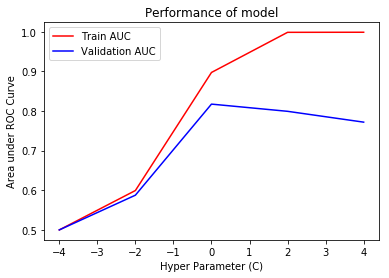

In [34]:
#Plotting performance of model during hyper parameter tuning
X = [log(y,10) for y in hypp_C]
plt.plot(X,train_auc,'r', label='Train AUC')
plt.plot(X,cv_auc,'b', label='Validation AUC')
# naming the x axis 
plt.xlabel('Hyper Parameter (C)') 
# naming the y axis 
plt.ylabel('Area under ROC Curve') 
# giving a title to my graph 
plt.title('Performance of model') 
# show a legend on the plot 
plt.legend() 
plt.show()

In [35]:
model = LogisticRegression(C=best_C, penalty='l1')
model.fit(final_counts, Y_train)

train_predicted_labels = []
for j in range(0, final_counts.get_shape()[0], 1000):
    train_predicted_labels.extend(model.predict(final_counts[j:j+1000]))
tr_auc = roc_auc_score(Y_train, train_predicted_labels)

test_predicted_labels = []
for j in range(0, test_counts.get_shape()[0], 1000):
    test_predicted_labels.extend(model.predict(test_counts[j:j+1000]))

auc = roc_auc_score(Y_test, test_predicted_labels)

print("For Optimal C = {}, AUC Score on Test set = {}".format(best_C,auc))
score_tracker["Bag of Words"] = ["Brute",best_C,auc]
w_l1 = model.coef_

For Optimal C = 1, AUC Score on Test set = 0.8164622177906404


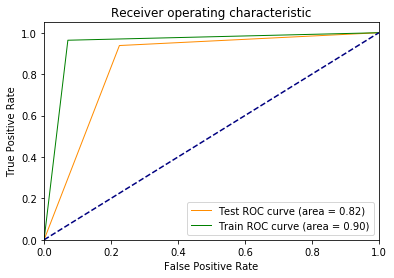

In [36]:
#ROC Curve on Train and Test set
#Reference- https://qiita.com/bmj0114/items/460424c110a8ce22d945
fpr2, tpr2, thresholds2 = roc_curve(train_predicted_labels, Y_train, pos_label=1)
fpr1, tpr1, thresholds1 = roc_curve(test_predicted_labels, Y_test, pos_label=1)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % auc)
plt.plot(fpr2, tpr2, color='green', lw=1, label='Train ROC curve (area = %0.2f)' % tr_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

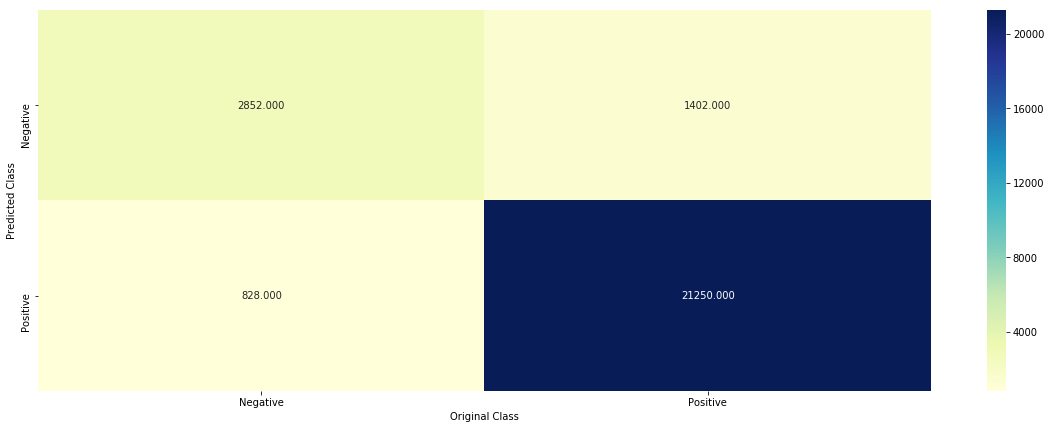


Confusion Matrix shows the number of points of Class i (Original Class - Y axis) that was predicted to be in Class j (Predicted Class - X axis)


In [37]:
#Confusion Matrix
Cm = confusion_matrix(Y_test,test_predicted_labels)
    
labels = ['Negative','Positive']

plt.figure(figsize=(20,7))
sns.heatmap(Cm, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Original Class')
plt.ylabel('Predicted Class')
plt.show()
    
print("\nConfusion Matrix shows the number of points of Class i (Original Class - Y axis) that was \
predicted to be in Class j (Predicted Class - X axis)")

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW

In [38]:
#https://stackoverflow.com/questions/38708621/how-to-calculate-percentage-of-sparsity-for-a-numpy-array-matrix
non_zero = np.count_nonzero(w_l1) #non-zero values in weight vector
total_values = np.product(w_l1.shape)

sparsity = (total_values - non_zero) / total_values
print("Percentage Sparsity = {} %".format(sparsity*100))

Percentage Sparsity = 90.47459462246398 %


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW

In [39]:
hypp_C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
auc_list = {}
cv_auc = []

for i in hypp_C:
    model_1 = LogisticRegression(C=i, penalty='l2')
    model_1.fit(final_counts, Y_train)

    predicted_labels = []
    for j in range(0, cv_counts.get_shape()[0], 1000):
          predicted_labels.extend(model_1.predict(cv_counts[j:j+1000]))

    # evaluate CV accuracy
    auc = roc_auc_score(Y_cv, predicted_labels)
    auc_list[i] = auc
    print('\nUsing L2 - AUC score on CV data for C = {0} is {1}'.format(i, auc))
    cv_auc.append(auc)

best_C = max(auc_list.keys(), key=(lambda key: auc_list[key]))
print("\nOptimal C = {}".format(best_C))

model_1 = LogisticRegression(C=best_C, penalty='l2')
model_1.fit(final_counts, Y_train)

test_predicted_labels = []
for j in range(0, test_counts.get_shape()[0], 1000):
    test_predicted_labels.extend(model.predict(test_counts[j:j+1000]))

auc = roc_auc_score(Y_test, test_predicted_labels)

print("\nUsing L2 - For Optimal C = {}, AUC Score on Test set = {}".format(best_C,auc))


Using L2 - AUC score on CV data for C = 0.0001 is 0.5

Using L2 - AUC score on CV data for C = 0.01 is 0.7053732982886036

Using L2 - AUC score on CV data for C = 1 is 0.8174383199214168


F:\Anaconda\envs\newpy\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Using L2 - AUC score on CV data for C = 100 is 0.8039107124194921


F:\Anaconda\envs\newpy\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Using L2 - AUC score on CV data for C = 10000 is 0.7966783154108235

Optimal C = 1

Using L2 - For Optimal C = 1, AUC Score on Test set = 0.8164622177906404


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW

In [40]:
test_df = count_vect.transform(X_train)

w0 = model.coef_

error = np.random.normal(0,0.1)
print("Added Error = ",error)

test_df.data = test_df.data + error

Added Error =  -0.1409598154341651


In [41]:
model_ptest = LogisticRegression(C=best_C, penalty='l1')
model_ptest.fit(test_df, Y_train)

w1 = model_ptest.coef_

#Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
w0 += 10^-6
w1 += 10^-6

#find the % change between W and W' (| (W-W') / (W) |)*100)
change = abs((w1-w0) / w0) *100

In [42]:
#Checking 0th, 10th, 20th, 30th, ..., 100th percentiles
per_value = 0
percentile_output = []
while per_value<=100:
    percentile_output.append(np.percentile(change, per_value))
    per_value +=10

print(percentile_output)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.66208192130977]


In [43]:
#Checking 99.1, 99.2, 99.3,..., 100th percentile values
per_value = 99.1
percentile_output = []
while per_value<=100:
    percentile_output.append(np.percentile(change, per_value))
    per_value += 0.1

print(percentile_output)

[1.157917393171936, 1.2428033239680065, 1.3520961830219795, 1.430404162508915, 1.5486712745301912, 1.687025779148015, 1.8541723785223907, 2.1288392944248464, 2.6863471389625038, 15.662081921137814]


In [44]:
#Obtain index of weights having % change > threshold value
index_max_change = np.where(change>mean(percentile_output)) #Considering mean value to be the threshold
print(index_max_change[1])

[  334  1704  2264  3703  7047  9610 10205 10980 12597 12758 16048 16953
 17697 18543 18590 20540 21514 24190 24368 25437 25949 30113 35124 36790]


In [45]:
#feature names whose % change is more than a threshold value 2
feat = list(np.take(count_vect.get_feature_names(), index_max_change[1]))
print(feat)

['adage', 'arabic', 'avocados', 'bonsais', 'conditioners', 'disabled', 'doughy', 'emeraldforest', 'filming', 'flagging', 'historically', 'incompetent', 'irresponsible', 'kickstarter', 'kindly', 'markings', 'mitts', 'ozs', 'pancreas', 'pinto', 'porous', 'selecting', 'torture', 'ventured']


### [5.1.3] Feature Importance on BOW

#### [5.1.3.1] Top 10 important features of positive class

In [46]:
#for Positive Class
index = w_l1.argsort(kind='quicksort')

top10 = {}
feat = list(np.take(count_vect.get_feature_names(), index[0][-10:]))
indx = []
for i in index[0][-10:]:
    indx.append(w_l1[0][i])
    
for it in range(0,10):
    top10[feat[it]] = indx[it]

print("Top 10 Features of Positive class and Weights:\n")

print('\n'.join("{}: {}".format(k, v) for k, v in top10.items()))

Top 10 Features of Positive class and Weights:

resist: -13.658296034248458
prescription: -13.614560954136438
beat: -13.612112426979014
corner: -13.524138462495864
sales: -13.248936471943567
addictive: -13.209202603592512
pedigree: -13.192619031697422
pleasantly: -12.271088090891077
worried: -12.21814172465043
emeraldforest: -9.740295837140591


#### [5.1.3.2] Top 10 important features of negative class

In [47]:
#for Negative Class
top10 = {}
feat = list(np.take(count_vect.get_feature_names(), index[0][:10]))
indx = []
for i in index[0][:10]:
    indx.append((w_l1[0][i]))
    
for it in range(0,10):
    top10[feat[it]] = indx[it]

print("Top 10 Features of Negative class and Weights:\n")

print('\n'.join("{}: {}".format(k, v) for k, v in top10.items()))

Top 10 Features of Negative class and Weights:

stassen: -21.626308491980804
unimpressed: -20.179033384964804
detangling: -20.030155835585518
unpleasantly: -19.761930387229945
ripoff: -19.448237006142612
undrinkable: -19.35209451816096
prizes: -19.261285328216367
unappealing: -19.20123253292976
worst: -19.140340706017604
metallic: -19.072701982330695


## [5.2] Logistic Regression on TFIDF

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF

In [48]:
hypp_C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
auc_list = {}
train_auc = []
cv_auc = []

for i in hypp_C:
    model = LogisticRegression(C=i, penalty='l1')
    model.fit(final_tf_idf, Y_train)
    
    train_predicted_labels = []
    for j in range(0, final_tf_idf.get_shape()[0], 1000):
          train_predicted_labels.extend(model.predict(final_tf_idf[j:j+1000]))
    tr_auc = roc_auc_score(Y_train, train_predicted_labels)
    train_auc.append(tr_auc)

    predicted_labels = []
    for j in range(0, cv_tfidf.get_shape()[0], 1000):
          predicted_labels.extend(model.predict(cv_tfidf[j:j+1000]))

    # evaluate CV accuracy
    auc = roc_auc_score(Y_cv, predicted_labels)
    auc_list[i] = auc
    print('\nAUC score on CV data for C = {0} is {1}'.format(i, auc))
    cv_auc.append(auc)

best_C = max(auc_list.keys(), key=(lambda key: auc_list[key]))
print("\nOptimal C = {}".format(best_C))


AUC score on CV data for C = 0.0001 is 0.5

AUC score on CV data for C = 0.01 is 0.5

AUC score on CV data for C = 1 is 0.8089412512637156

AUC score on CV data for C = 100 is 0.8447326658843379

AUC score on CV data for C = 10000 is 0.8290177792542704

Optimal C = 100


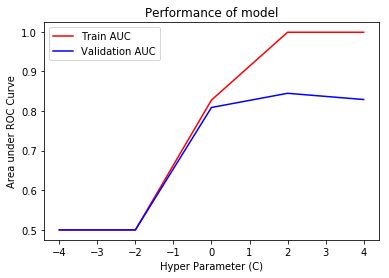

In [49]:
#Plotting performance of model during hyper parameter tuning
X = [log(y,10) for y in hypp_C]
plt.plot(X,train_auc,'r', label='Train AUC')
plt.plot(X,cv_auc,'b', label='Validation AUC')
# naming the x axis 
plt.xlabel('Hyper Parameter (C)') 
# naming the y axis 
plt.ylabel('Area under ROC Curve') 
# giving a title to my graph 
plt.title('Performance of model') 
# show a legend on the plot 
plt.legend() 
plt.show()

In [50]:
model = LogisticRegression(C=best_C, penalty='l1')
model.fit(final_tf_idf, Y_train)

train_predicted_labels = []
for j in range(0, final_tf_idf.get_shape()[0], 1000):
    train_predicted_labels.extend(model.predict(final_tf_idf[j:j+1000]))
tr_auc = roc_auc_score(Y_train, train_predicted_labels)

test_predicted_labels = []
for j in range(0, test_tfidf.get_shape()[0], 1000):
    test_predicted_labels.extend(model.predict(test_tfidf[j:j+1000]))

auc = roc_auc_score(Y_test, test_predicted_labels)

print("For Optimal C = {}, AUC Score on Test set = {}".format(best_C,auc))
score_tracker["TF-IDF"] = ["Brute",best_C,auc]
w_l1 = model.coef_

For Optimal C = 100, AUC Score on Test set = 0.8417515252266476


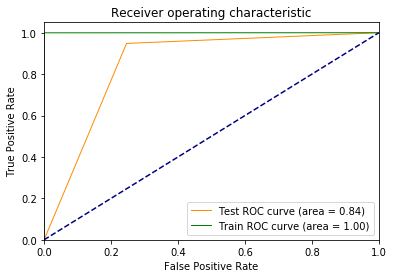

In [51]:
#ROC Curve on Train and Test set
#Reference- https://qiita.com/bmj0114/items/460424c110a8ce22d945
fpr2, tpr2, thresholds2 = roc_curve(train_predicted_labels, Y_train, pos_label=1)
fpr1, tpr1, thresholds1 = roc_curve(test_predicted_labels, Y_test, pos_label=1)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % auc)
plt.plot(fpr2, tpr2, color='green', lw=1, label='Train ROC curve (area = %0.2f)' % tr_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

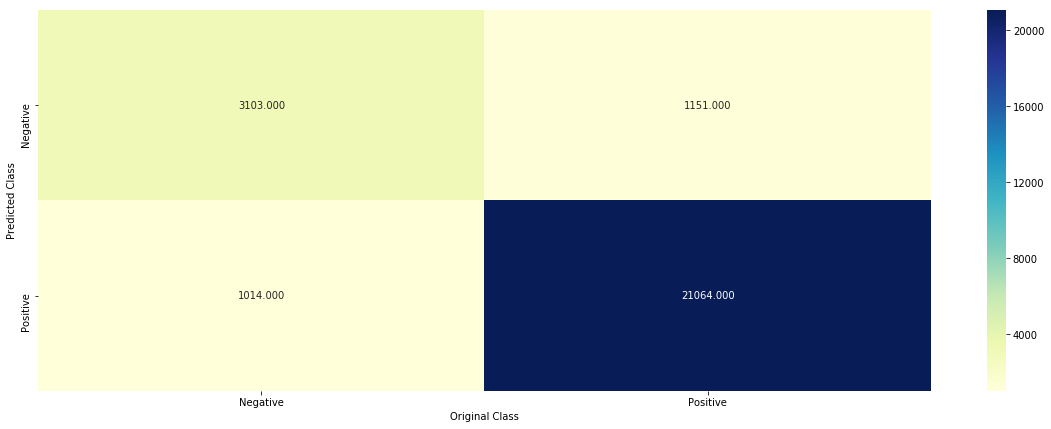


Confusion Matrix shows the number of points of Class i (Original Class - Y axis) that was predicted to be in Class j (Predicted Class - X axis)


In [52]:
#Confusion Matrix
Cm = confusion_matrix(Y_test,test_predicted_labels)
    
labels = ['Negative','Positive']

plt.figure(figsize=(20,7))
sns.heatmap(Cm, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Original Class')
plt.ylabel('Predicted Class')
plt.show()
    
print("\nConfusion Matrix shows the number of points of Class i (Original Class - Y axis) that was \
predicted to be in Class j (Predicted Class - X axis)")

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF

In [53]:
hypp_C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
auc_list = {}
cv_auc = []

for i in hypp_C:
    model_1 = LogisticRegression(C=i, penalty='l2')
    model_1.fit(final_tf_idf, Y_train)

    predicted_labels = []
    for j in range(0, cv_tfidf.get_shape()[0], 1000):
          predicted_labels.extend(model_1.predict(cv_tfidf[j:j+1000]))

    # evaluate CV accuracy
    auc = roc_auc_score(Y_cv, predicted_labels)
    auc_list[i] = auc
    print('\nUsing L2 - AUC score on CV data for C = {0} is {1}'.format(i, auc))
    cv_auc.append(auc)

best_C = max(auc_list.keys(), key=(lambda key: auc_list[key]))
print("\nOptimal C = {}".format(best_C))

model_1 = LogisticRegression(C=best_C, penalty='l2')
model_1.fit(final_tf_idf, Y_train)

test_predicted_labels = []
for j in range(0, test_tfidf.get_shape()[0], 1000):
    test_predicted_labels.extend(model_1.predict(test_tfidf[j:j+1000]))

auc = roc_auc_score(Y_test, test_predicted_labels)

print("\nUsing L2 - For Optimal C = {}, AUC Score on Test set = {}".format(best_C,auc))


Using L2 - AUC score on CV data for C = 0.0001 is 0.5

Using L2 - AUC score on CV data for C = 0.01 is 0.5

Using L2 - AUC score on CV data for C = 1 is 0.778108773081754

Using L2 - AUC score on CV data for C = 100 is 0.843291785614728

Using L2 - AUC score on CV data for C = 10000 is 0.8418170215789292

Optimal C = 100

Using L2 - For Optimal C = 100, AUC Score on Test set = 0.8403685475861047


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [54]:
#for Positive Class
index = w_l1.argsort(kind='quicksort')

top10 = {}
feat = list(np.take(tf_idf_vect.get_feature_names(), index[0][-10:]))
indx = []
for i in index[0][-10:]:
    indx.append(w_l1[0][i])
    
for it in range(0,10):
    top10[feat[it]] = indx[it]

print("Top 10 Features of Positive class and Weights:\n")

print('\n'.join("{}: {}".format(k, v) for k, v in top10.items()))

Top 10 Features of Positive class and Weights:

excellent: 43.54335048748732
buying amazon: 43.57201275437338
freshener: 44.358286920738614
mixed fruit: 45.461620523123436
good size: 49.391387787621376
not processed: 50.19179364544838
great: 50.539587484258334
delicious: 50.57771695785762
smaller bag: 52.4164156364786
not disappointed: 90.28690845833977


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [55]:
#for Negative Class
top10 = {}
feat = list(np.take(tf_idf_vect.get_feature_names(), index[0][:10]))
indx = []
for i in index[0][:10]:
    indx.append(w_l1[0][i])
    
for it in range(0,10):
    top10[feat[it]] = indx[it]

print("Top 10 Features of Negative class and Weights:\n")

print('\n'.join("{}: {}".format(k, v) for k, v in top10.items()))

Top 10 Features of Negative class and Weights:

two stars: -74.28186701809162
worst: -55.401868821274505
severely: -55.28594252865846
canceled: -54.958645185014504
ripoff: -53.14753565176214
not worth: -51.08972113340166
still no: -47.56357862796911
disappointed like: -45.96214648465264
inedible: -45.118648877707535
ruins: -44.07787951285665


## [5.3] Logistic Regression on AVG W2V

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V

In [57]:
train_vec = normalize(np.nan_to_num(train_sent_vec))
cv_vec = normalize(np.nan_to_num(cv_sent_vec))
test_vec = normalize(np.nan_to_num(test_sent_vec))

In [58]:
hypp_C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
auc_list = {}
train_auc = []
cv_auc = []

for i in hypp_C:
    model = LogisticRegression(C=i, penalty='l1')
    model.fit(train_vec, Y_train)
    
    train_predicted_labels = []
    for j in range(0, len(train_vec), 1000):
          train_predicted_labels.extend(model.predict(train_vec[j:j+1000]))
    tr_auc = roc_auc_score(Y_train, train_predicted_labels)
    train_auc.append(tr_auc)

    predicted_labels = []
    for j in range(0, len(cv_vec), 1000):
          predicted_labels.extend(model.predict(cv_vec[j:j+1000]))

    # evaluate CV accuracy
    auc = roc_auc_score(Y_cv, predicted_labels)
    auc_list[i] = auc
    print('\nAUC score on CV data for C = {0} is {1}'.format(i, auc))
    cv_auc.append(auc)

best_C = max(auc_list.keys(), key=(lambda key: auc_list[key]))
print("\nOptimal C = {}".format(best_C))


AUC score on CV data for C = 0.0001 is 0.5

AUC score on CV data for C = 0.01 is 0.6094717456755558

AUC score on CV data for C = 1 is 0.7352207681088034

AUC score on CV data for C = 100 is 0.7369120232291198

AUC score on CV data for C = 10000 is 0.7369120232291198

Optimal C = 100


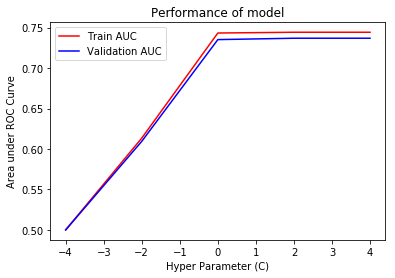

In [59]:
#Plotting performance of model during hyper parameter tuning
X = [log(y,10) for y in hypp_C]
plt.plot(X,train_auc,'r', label='Train AUC')
plt.plot(X,cv_auc,'b', label='Validation AUC')
# naming the x axis 
plt.xlabel('Hyper Parameter (C)') 
# naming the y axis 
plt.ylabel('Area under ROC Curve') 
# giving a title to my graph 
plt.title('Performance of model') 
# show a legend on the plot 
plt.legend() 
plt.show()

In [60]:
model = LogisticRegression(C=best_C, penalty='l1')
model.fit(train_vec, Y_train)

train_predicted_labels = []
for j in range(0, len(train_vec), 1000):
    train_predicted_labels.extend(model.predict(train_vec[j:j+1000]))
tr_auc = roc_auc_score(Y_train, train_predicted_labels)

test_predicted_labels = []
for j in range(0, len(test_vec), 1000):
    test_predicted_labels.extend(model.predict(test_vec[j:j+1000]))

auc = roc_auc_score(Y_test, test_predicted_labels)

print("For Optimal C = {}, AUC Score on Test set = {}".format(best_C,auc))
score_tracker["Avg Word2Vec"] = ["Brute",best_C,auc]

For Optimal C = 100, AUC Score on Test set = 0.7411095967696357


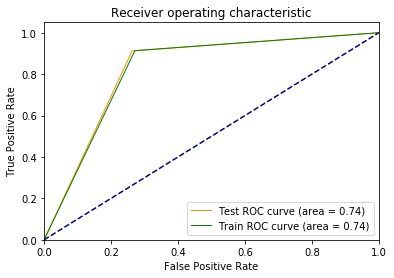

In [61]:
#ROC Curve on Train and Test set
#Reference- https://qiita.com/bmj0114/items/460424c110a8ce22d945
fpr2, tpr2, thresholds2 = roc_curve(train_predicted_labels, Y_train, pos_label=1)
fpr1, tpr1, thresholds1 = roc_curve(test_predicted_labels, Y_test, pos_label=1)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % auc)
plt.plot(fpr2, tpr2, color='green', lw=1, label='Train ROC curve (area = %0.2f)' % tr_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

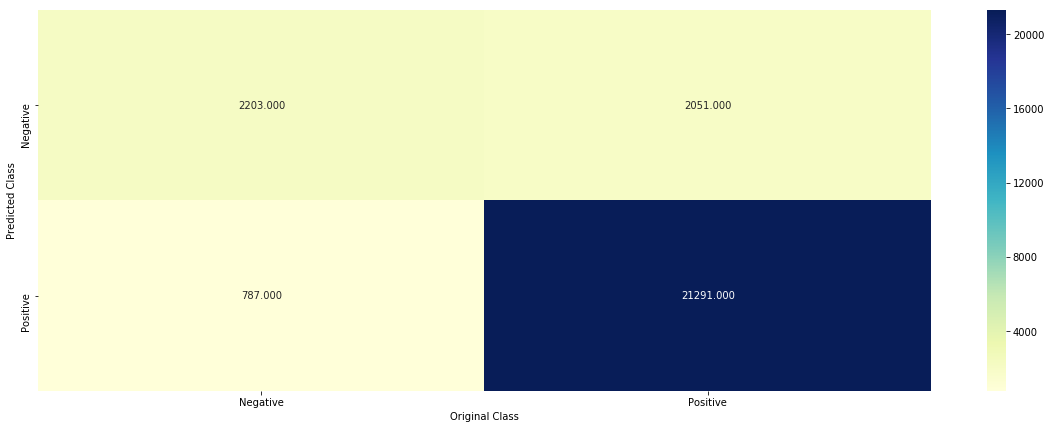


Confusion Matrix shows the number of points of Class i (Original Class - Y axis) that was predicted to be in Class j (Predicted Class - X axis)


In [62]:
#Confusion Matrix
Cm = confusion_matrix(Y_test,test_predicted_labels)
    
labels = ['Negative','Positive']

plt.figure(figsize=(20,7))
sns.heatmap(Cm, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Original Class')
plt.ylabel('Predicted Class')
plt.show()
    
print("\nConfusion Matrix shows the number of points of Class i (Original Class - Y axis) that was \
predicted to be in Class j (Predicted Class - X axis)")

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V

In [63]:
hypp_C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
auc_list = {}
cv_auc = []

for i in hypp_C:
    model_1 = LogisticRegression(C=i, penalty='l2')
    model_1.fit(train_vec, Y_train)

    predicted_labels = []
    for j in range(0, len(cv_vec), 1000):
          predicted_labels.extend(model_1.predict(cv_vec[j:j+1000]))

    # evaluate CV accuracy
    auc = roc_auc_score(Y_cv, predicted_labels)
    auc_list[i] = auc
    print('\nUsing L2 - AUC score on CV data for C = {0} is {1}'.format(i, auc))
    cv_auc.append(auc)

best_C = max(auc_list.keys(), key=(lambda key: auc_list[key]))
print("\nOptimal C = {}".format(best_C))

model_1 = LogisticRegression(C=best_C, penalty='l2')
model_1.fit(train_vec, Y_train)

test_predicted_labels = []
for j in range(0, len(test_vec), 1000):
    test_predicted_labels.extend(model_1.predict(test_vec[j:j+1000]))

auc = roc_auc_score(Y_test, test_predicted_labels)

print("\nUsing L2 - For Optimal C = {}, AUC Score on Test set = {}".format(best_C,auc))


Using L2 - AUC score on CV data for C = 0.0001 is 0.5

Using L2 - AUC score on CV data for C = 0.01 is 0.5885603342879596

Using L2 - AUC score on CV data for C = 1 is 0.7332199311721741

Using L2 - AUC score on CV data for C = 100 is 0.7367441253110538

Using L2 - AUC score on CV data for C = 10000 is 0.7367441253110538

Optimal C = 100

Using L2 - For Optimal C = 100, AUC Score on Test set = 0.741227133205931


## [5.4] Logistic Regression on TFIDF W2V

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V

In [65]:
hypp_C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
auc_list = {}
train_auc = []
cv_auc = []

for i in hypp_C:
    model = LogisticRegression(C=i, penalty='l1')
    model.fit(weighted_train_vec, Y_train)
    
    train_predicted_labels = []
    for j in range(0, len(weighted_train_vec), 1000):
          train_predicted_labels.extend(model.predict(weighted_train_vec[j:j+1000]))
    tr_auc = roc_auc_score(Y_train, train_predicted_labels)
    train_auc.append(tr_auc)

    predicted_labels = []
    for j in range(0, len(weighted_cv_vec), 1000):
          predicted_labels.extend(model.predict(weighted_cv_vec[j:j+1000]))

    # evaluate CV accuracy
    auc = roc_auc_score(Y_cv, predicted_labels)
    auc_list[i] = auc
    print('\nAUC score on CV data for C = {0} is {1}'.format(i, auc))
    cv_auc.append(auc)

best_C = max(auc_list.keys(), key=(lambda key: auc_list[key]))
print("\nOptimal C = {}".format(best_C))


AUC score on CV data for C = 0.0001 is 0.5

AUC score on CV data for C = 0.01 is 0.655941619976452

AUC score on CV data for C = 1 is 0.6916598895513069

AUC score on CV data for C = 100 is 0.6922667772442754

AUC score on CV data for C = 10000 is 0.6922667772442754

Optimal C = 100


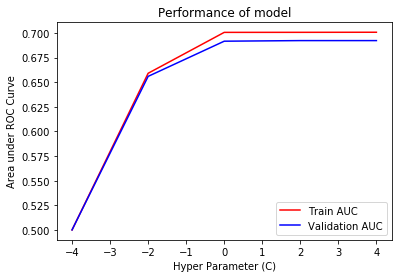

In [66]:
#Plotting performance of model during hyper parameter tuning
X = [log(y,10) for y in hypp_C]
plt.plot(X,train_auc,'r', label='Train AUC')
plt.plot(X,cv_auc,'b', label='Validation AUC')
# naming the x axis 
plt.xlabel('Hyper Parameter (C)') 
# naming the y axis 
plt.ylabel('Area under ROC Curve') 
# giving a title to my graph 
plt.title('Performance of model') 
# show a legend on the plot 
plt.legend() 
plt.show()

In [67]:
model = LogisticRegression(C=best_C, penalty='l1')
model.fit(weighted_train_vec, Y_train)

train_predicted_labels = []
for j in range(0, len(weighted_train_vec), 1000):
    train_predicted_labels.extend(model.predict(weighted_train_vec[j:j+1000]))
tr_auc = roc_auc_score(Y_train, train_predicted_labels)

test_predicted_labels = []
for j in range(0, len(weighted_test_vec), 1000):
    test_predicted_labels.extend(model.predict(weighted_test_vec[j:j+1000]))

auc = roc_auc_score(Y_test, test_predicted_labels)

print("For Optimal C = {}, AUC Score on Test set = {}".format(best_C,auc))
score_tracker["TF-IDF weighted Word2Vec"] = ["Brute",best_C,auc]

For Optimal C = 100, AUC Score on Test set = 0.6964976250165407


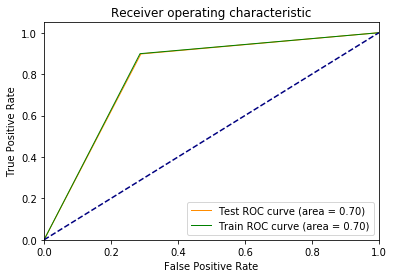

In [68]:
#ROC Curve on Train and Test set
#Reference- https://qiita.com/bmj0114/items/460424c110a8ce22d945
fpr2, tpr2, thresholds2 = roc_curve(train_predicted_labels, Y_train, pos_label=1)
fpr1, tpr1, thresholds1 = roc_curve(test_predicted_labels, Y_test, pos_label=1)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % auc)
plt.plot(fpr2, tpr2, color='green', lw=1, label='Train ROC curve (area = %0.2f)' % tr_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

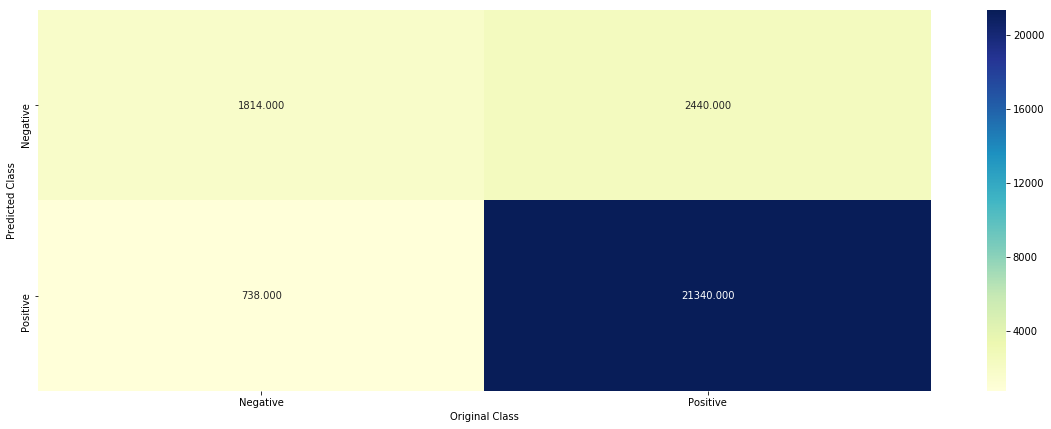


Confusion Matrix shows the number of points of Class i (Original Class - Y axis) that was predicted to be in Class j (Predicted Class - X axis)


In [69]:
#Confusion Matrix
Cm = confusion_matrix(Y_test,test_predicted_labels)
    
labels = ['Negative','Positive']

plt.figure(figsize=(20,7))
sns.heatmap(Cm, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Original Class')
plt.ylabel('Predicted Class')
plt.show()
    
print("\nConfusion Matrix shows the number of points of Class i (Original Class - Y axis) that was \
predicted to be in Class j (Predicted Class - X axis)")

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V

In [70]:
# Please write all the code with proper documentation
hypp_C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
auc_list = {}
cv_auc = []

for i in hypp_C:
    model_1 = LogisticRegression(C=i, penalty='l2')
    model_1.fit(weighted_train_vec, Y_train)

    predicted_labels = []
    for j in range(0, len(weighted_cv_vec), 1000):
          predicted_labels.extend(model_1.predict(weighted_cv_vec[j:j+1000]))

    # evaluate CV accuracy
    auc = roc_auc_score(Y_cv, predicted_labels)
    auc_list[i] = auc
    print('\nUsing L2 - AUC score on CV data for C = {0} is {1}'.format(i, auc))
    cv_auc.append(auc)

best_C = max(auc_list.keys(), key=(lambda key: auc_list[key]))
print("\nOptimal C = {}".format(best_C))

model_1 = LogisticRegression(C=best_C, penalty='l2')
model_1.fit(weighted_train_vec, Y_train)

test_predicted_labels = []
for j in range(0, len(weighted_test_vec), 1000):
    test_predicted_labels.extend(model_1.predict(weighted_test_vec[j:j+1000]))

auc = roc_auc_score(Y_test, test_predicted_labels)

print("\nUsing L2 - For Optimal C = {}, AUC Score on Test set = {}".format(best_C,auc))


Using L2 - AUC score on CV data for C = 0.0001 is 0.5021179689555609

Using L2 - AUC score on CV data for C = 0.01 is 0.6711707161696286

Using L2 - AUC score on CV data for C = 1 is 0.6916275375616594

Using L2 - AUC score on CV data for C = 100 is 0.6919309814081438

Using L2 - AUC score on CV data for C = 10000 is 0.6920988793262095

Optimal C = 10000

Using L2 - For Optimal C = 10000, AUC Score on Test set = 0.6963574416013525


# [6] Conclusions

In [71]:
# Please compare all your models using Prettytable library
table = PrettyTable()
table.field_names = ["Vectorizer","Model","Hyper Parameter","AUC"]

for key,value in score_tracker.items():
    table.add_row([key,value[0],value[1],value[2]])
table.sortby = "AUC"
table.reversesort = True
print(table)

+--------------------------+-------+-----------------+--------------------+
|        Vectorizer        | Model | Hyper Parameter |        AUC         |
+--------------------------+-------+-----------------+--------------------+
|          TF-IDF          | Brute |       100       | 0.8417515252266476 |
|       Bag of Words       | Brute |        1        | 0.8164622177906404 |
|       Avg Word2Vec       | Brute |       100       | 0.7411095967696357 |
| TF-IDF weighted Word2Vec | Brute |       100       | 0.6964976250165407 |
+--------------------------+-------+-----------------+--------------------+
